# ทำความเข้าใจข้อมูลฝนเรดาร์รายวัน

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import linregress
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Read and cleansing data

In [2]:
df = pd.read_csv('./00Results/00rain_radar_hourly_extracted_all_events_mean_dBZ/df_org_dbz_rain_test120km.csv')
df.drop(df[df['rain_x'] <= 0].index, inplace = True) # ทดสอบการตัดฝนอ่อนตรงนี้้ได 0, 0.5,1.0
#df.drop(df[df['rain_x'] < 1.0].index, inplace = True) # ทดสอบการตัดฝนอ่อนตรงนี้้ได 0, 0.5,1.0
#df.drop(df[df['cappi1km'] < 10].index, inplace = True) #ฝนอ่่อนมากๆ < 10 dBZ
#df.drop(df[df['cappi4km'] > 55].index, inplace = True) #ค่าการสะท้อนที่อาจเป็นลูกเห็บ 55 dBZ มุมยกด้านบนสุด
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
#df.reset_index(drop=True)
#df.dropna(inplace=True)
df

,cappi1km,cappi2km,cappi3km,cappi4km,full_date,code,rain_x
6,NaN,NaN,NaN,NaN,2018-06-01-00:00,CTKN,10.8
28,NaN,NaN,NaN,NaN,2018-06-01-00:00,NMPR,3.6
72,22.267728,22.656334,23.252944,23.492632,2018-06-01-01:00,CMSG,0.4
107,37.450751,35.934908,34.647741,31.643592,2018-06-01-01:00,PIN004,0.2
138,28.847841,28.025389,26.520176,24.078056,2018-06-01-02:00,CMSG,0.2
...,...,...,...,...,...,...,...
68305,NaN,NaN,NaN,NaN,2018-09-21-18:00,CNDN,0.4
68328,NaN,NaN,NaN,NaN,2018-09-21-18:00,NAN005,1.0
68334,18.423027,18.423027,18.423027,NaN,2018-09-21-18:00,NGBA,0.8
68411,29.833809,NaN,NaN,NaN,2018-09-21-19:00,NAN013,24.8


In [3]:
df.rename(columns={"cappi1km": "dBZ_c1", "cappi2km": "dBZ_c2","cappi3km": "dBZ_c3","cappi4km": "dBZ_c4"}, inplace=True)
df.rename(columns={"rain_x":"rain_truth"}, inplace=True)
df

,dBZ_c1,dBZ_c2,dBZ_c3,dBZ_c4,full_date,code,rain_truth
6,NaN,NaN,NaN,NaN,2018-06-01-00:00,CTKN,10.8
28,NaN,NaN,NaN,NaN,2018-06-01-00:00,NMPR,3.6
72,22.267728,22.656334,23.252944,23.492632,2018-06-01-01:00,CMSG,0.4
107,37.450751,35.934908,34.647741,31.643592,2018-06-01-01:00,PIN004,0.2
138,28.847841,28.025389,26.520176,24.078056,2018-06-01-02:00,CMSG,0.2
...,...,...,...,...,...,...,...
68305,NaN,NaN,NaN,NaN,2018-09-21-18:00,CNDN,0.4
68328,NaN,NaN,NaN,NaN,2018-09-21-18:00,NAN005,1.0
68334,18.423027,18.423027,18.423027,NaN,2018-09-21-18:00,NGBA,0.8
68411,29.833809,NaN,NaN,NaN,2018-09-21-19:00,NAN013,24.8


### คำนวณฝนประมาณค่าจากเรดาร์ค่าด้วย ZR Vectorized Operations:

In [4]:
#  Vectorized Operations:
constants = {
    'MP': (200, 1.6), # ZR marshall/palmer
    'RF': (250, 1.2), # ZR Rosenfeld
    'SC': (300, 1.4) # ZR Summer Deep Convection
}

for prefix, (a, b) in constants.items():
    for suffix in ['c1', 'c2', 'c3', 'c4']:
        dBZ_column = f'dBZ_{suffix}'
        rr_column = f'rr_{prefix}_{suffix}'
        df[rr_column] = ((10**(df[dBZ_column]/10.))/a)**(1/b)

In [5]:
#### ดรอปคอมลัมน์ cappi ทิ้ง
df.drop(columns=['dBZ_c1','dBZ_c2','dBZ_c3','dBZ_c4'], inplace=True) #ลบคอลัน์
df

,full_date,code,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
6,2018-06-01-00:00,CTKN,10.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,2018-06-01-00:00,NMPR,3.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,2018-06-01-01:00,CMSG,0.4,0.898647,0.950336,1.035536,1.071879,0.720047,0.775791,0.869885,0.910827,0.662491,0.706216,0.779027,0.810350
107,2018-06-01-01:00,PIN004,0.2,7.989658,6.423741,5.337527,3.464023,13.262108,9.914991,7.745125,4.351938,8.047877,6.272011,5.075354,3.096594
138,2018-06-01-02:00,CMSG,0.2,2.316575,2.057989,1.657171,1.166097,2.545092,2.173530,1.628288,1.019111,1.955185,1.707816,1.333294,0.892255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68305,2018-09-21-18:00,CNDN,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68328,2018-09-21-18:00,NAN005,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68334,2018-09-21-18:00,NGBA,0.8,0.516768,0.516768,0.516768,NaN,0.344325,0.344325,0.344325,NaN,0.352013,0.352013,0.352013,NaN
68411,2018-09-21-19:00,NAN013,24.8,2.669742,NaN,NaN,NaN,3.075158,NaN,NaN,NaN,2.299397,NaN,NaN,NaN


In [6]:
df.dropna(inplace=True)
df.reset_index(drop=True)

,full_date,code,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
0,2018-06-01-01:00,CMSG,0.4,0.898647,0.950336,1.035536,1.071879,0.720047,0.775791,0.869885,0.910827,0.662491,0.706216,0.779027,0.810350
1,2018-06-01-01:00,PIN004,0.2,7.989658,6.423741,5.337527,3.464023,13.262108,9.914991,7.745125,4.351938,8.047877,6.272011,5.075354,3.096594
2,2018-06-01-02:00,CMSG,0.2,2.316575,2.057989,1.657171,1.166097,2.545092,2.173530,1.628288,1.019111,1.955185,1.707816,1.333294,0.892255
3,2018-06-01-02:00,NSRS,2.8,26.740589,25.118143,21.500539,16.534742,66.395140,61.078967,49.641029,34.976114,32.009071,29.799314,24.947083,18.478841
4,2018-06-01-03:00,CMSG,0.2,5.971266,4.801238,4.734323,5.353180,8.994911,6.725314,6.600631,7.775424,5.769704,4.496865,4.425311,5.092368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2601,2018-09-20-16:00,TGSK,0.8,0.871279,1.291773,1.794893,1.963920,0.690957,1.168127,1.811173,2.042083,0.639483,1.002976,1.460664,1.618897
2602,2018-09-20-17:00,PAS003,2.6,7.637749,6.846747,5.652252,4.423040,12.489034,10.794950,8.359949,6.028410,7.644055,6.746207,5.418789,4.094371
2603,2018-09-20-17:00,TGSK,0.2,0.816687,1.046085,1.194923,1.347858,0.633844,0.881721,1.052838,1.236234,0.593899,0.788103,0.917506,1.052896
2604,2018-09-21-14:00,PIN003,2.4,3.570917,3.593265,3.415970,2.660618,4.531911,4.569766,4.271631,3.061153,3.206039,3.228980,3.047550,2.290418


In [7]:
# Extract date from 'full_date' column
df['date_only'] = pd.to_datetime(df['full_date']).dt.date

# Group by 'date_only' and 'code', then sum the 'rain_truth' values
aggregated_data = df.groupby(['date_only', 'code']).sum().reset_index()

# replace NaN with 0 after aggregation using fillna(0)
#aggregated_data.fillna(0, inplace=True)

aggregated_data.dropna(inplace=True)
aggregated_data.reset_index(drop=True)

aggregated_data.head()

,date_only,code,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
0,2018-06-01,BPPS,0.2,0.521811,0.537409,0.514784,0.728067,0.348813,0.362784,0.342564,0.543838,0.355941,0.368127,0.350468,0.520837
1,2018-06-01,CMSG,4.8,14.106057,12.901962,13.043754,13.905886,17.889174,15.588196,15.889232,17.639627,12.607459,11.306208,11.467976,12.430482
2,2018-06-01,KGKG,0.4,1.516191,1.607534,1.663254,1.650111,1.161252,1.245015,1.301619,1.285351,1.095590,1.167728,1.213664,1.201826
3,2018-06-01,KGLN,0.2,1.059222,1.063777,1.091251,1.158034,0.896515,0.901660,0.932841,1.009726,0.799424,0.803354,0.827109,0.885207
4,2018-06-01,KOKO,19.4,2.954353,2.936022,2.968597,3.049001,3.020454,3.010823,3.027016,3.069290,2.409088,2.396904,2.418280,2.472085


In [8]:
# conditional rain
df_=aggregated_data[aggregated_data['rain_truth']>0]
df_=df_[df_['rr_SC_c1']>0]
df_.reset_index(drop=True, inplace=True)
df_.describe()
df=df_

## Feature analysis

###  Correlation matrix analysis:

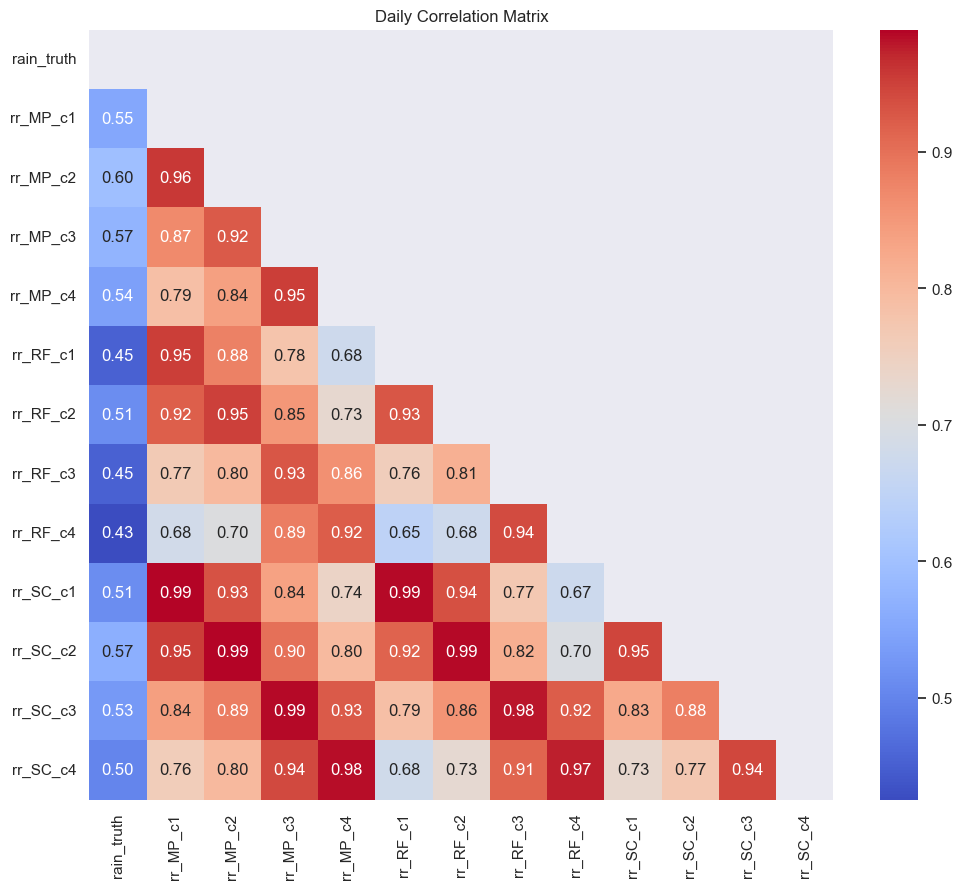

important_features_corr: ['rain_truth', 'rr_MP_c2', 'rr_MP_c3', 'rr_SC_c2', 'rr_MP_c1', 'rr_MP_c4', 'rr_SC_c3', 'rr_RF_c2', 'rr_SC_c1', 'rr_SC_c4', 'rr_RF_c3', 'rr_RF_c1', 'rr_RF_c4']


In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.corr()

# Create a mask for the lower triangular part
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set the font scale for the heatmap
sns.set(font_scale=1.0)  # Adjust the font scale as needed

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title("Daily Correlation Matrix")
plt.show()

# Identify features highly correlated with the target
correlation_with_target = correlation_matrix['rain_truth'].abs().sort_values(ascending=False)
important_features_corr = correlation_with_target[correlation_with_target > 0.20].index.tolist()
print('important_features_corr:', important_features_corr)


## Density scatter plot

In [10]:
def density_plot(rain_truth, rain_radar, max_=15):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde
    from scipy.stats import linregress
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    

    font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 22}

    plt.rc('font', **font)

    
    SMALL_SIZE = 12
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 16

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    # data
    x = rain_radar
    y = rain_truth

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    # Set the desired colorbar range
    cbar_min = 0.005  # specify your minimum value
    cbar_max = 0.015 # specify your maximum value

    # Create scatter plot with density color map
    fig, ax = plt.subplots()
    scatter = ax.scatter(x, y, c=z, s=40, cmap='rainbow', alpha=0.6, vmin=cbar_min, vmax=cbar_max)

    # Set x and y axis limits
    plt.xlim(0, max_)
    plt.ylim(0, max_)

    # Plot the 1:1 line
    plt.plot([0, max_], [0, max_], linestyle='--', color='grey', linewidth=2)

    # Set font size for axis labels and title
    plt.xlabel('radar rainfall [mm/day]')
    plt.ylabel('gauge rainfall [mm/day]')
    plt.title('Comparison daily radar and gauge rainfall', fontsize=16)

    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density', fontsize=14)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(x, y))
    mse = mean_squared_error(x, y)
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)

    # Calculate p-value and correlation coefficient (r)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Plot the regression line
    #plt.plot(x, slope * x + intercept, linestyle='-', color='magenta', linewidth=2,
    #         label=f'Regression Line (r={r_value:.2f}, p={p_value:.4f})')
    
    # Set font size for legend
    plt.legend(fontsize=12)

    # Display the plot
    plt.show()
    
    print(slope, intercept)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


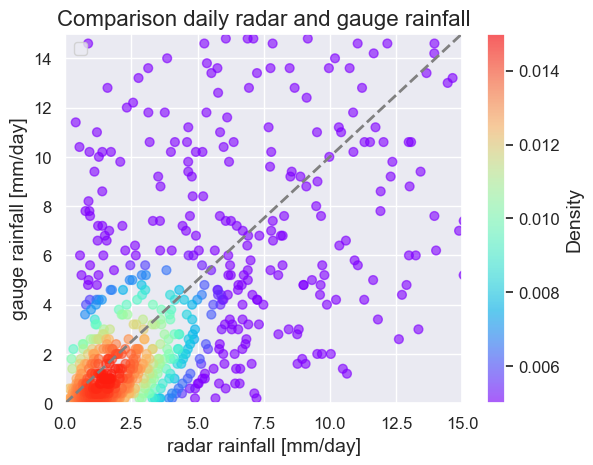

0.8058215742829683 1.8568862051144235


In [11]:
density_plot(df['rain_truth'],df['rr_MP_c2'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


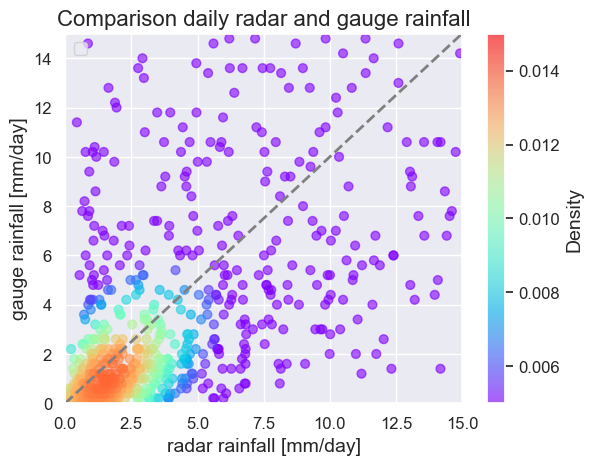

0.737312476626667 2.062587660355934


In [12]:
density_plot(df['rain_truth'],df['rr_MP_c3'])

## คำนวณค่าสถิติโดยรวมระหว่างเรดาร์กับฝนสถานีในแต่ละตัวแปรแล้วเก็บไว้ใน dataframe

In [13]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import linregress

def cal_metrics(x, y):    
    rmse = np.sqrt(mean_squared_error(x, y))
    mse = mean_squared_error(x, y)
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)
    mfb = x.sum(axis=0) / y.sum(axis=0)
    
    # Calculate p-value and correlation coefficient (r)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    return {
        "RMSE": rmse,
        "MSE": mse,
        "MAE": mae,
        "R-squared": r2,
        "MFB": mfb,
        "Correlation coefficient (r)": r_value,
        "P-value": p_value
    }

# Filter columns with prefix 'rr_'
rr_columns = df.filter(like='rr_')

# Calculate metrics for each column
metrics_results = {}
for column in rr_columns.columns:
    metrics_results[column] = cal_metrics(rr_columns[column], df['rain_truth'])

# Create DataFrame from the results
metrics_df = pd.DataFrame(metrics_results).T

# Display the DataFrame
print(metrics_df)


               RMSE         MSE       MAE  R-squared       MFB  \
rr_MP_c1   8.025773   64.413032  4.238421  -0.206874  0.865967   
rr_MP_c2   7.548167   56.974823  4.045723  -0.232466  0.864055   
rr_MP_c3   7.789896   60.682483  4.231050  -0.187184  0.898707   
rr_MP_c4   8.022791   64.365174  4.376579  -0.303686  0.885683   
rr_RF_c1  14.072947  198.047847  5.799867   0.176757  1.222272   
rr_RF_c2  11.885513  141.265411  5.296827   0.228328  1.181694   
rr_RF_c3  14.077115  198.165154  5.522540   0.177340  1.247630   
rr_RF_c4  13.694113  187.528722  5.526864   0.135017  1.190530   
rr_SC_c1   8.642117   74.686192  4.315023  -0.170587  0.796648   
rr_SC_c2   7.957344   63.319325  4.069231  -0.214315  0.786150   
rr_SC_c3   8.397307   70.514759  4.228702  -0.160349  0.822347   
rr_SC_c4   8.549656   73.096624  4.323741  -0.296520  0.800961   

          Correlation coefficient (r)       P-value  
rr_MP_c1                     0.552174  4.932250e-78  
rr_MP_c2                     0.59

In [14]:
# Define formatters for each column
formatters = {
    "RMSE": "{:.3f}",
    "MSE": "{:.3f}",
    "MAE": "{:.3f}",
    "R-squared": "{:.3f}",
    "MFB": "{:.3f}",
    "Correlation coefficient (r)": "{:.3f}",
    "P-value": "{:.3f}"
}

# Apply formatting to the DataFrame
styled_df = metrics_df.style.format(formatters)

# Display the styled DataFrame
styled_df


,RMSE,MSE,MAE,R-squared,MFB,Correlation coefficient (r),P-value
rr_MP_c1,8.026,64.413,4.238,-0.207,0.866,0.552,0.000
rr_MP_c2,7.548,56.975,4.046,-0.232,0.864,0.596,0.000
rr_MP_c3,7.790,60.682,4.231,-0.187,0.899,0.573,0.000
rr_MP_c4,8.023,64.365,4.377,-0.304,0.886,0.542,0.000
rr_RF_c1,14.073,198.048,5.800,0.177,1.222,0.452,0.000
rr_RF_c2,11.886,141.265,5.297,0.228,1.182,0.513,0.000
rr_RF_c3,14.077,198.165,5.523,0.177,1.248,0.454,0.000
rr_RF_c4,13.694,187.529,5.527,0.135,1.191,0.425,0.000
rr_SC_c1,8.642,74.686,4.315,-0.171,0.797,0.512,0.000
rr_SC_c2,7.957,63.319,4.069,-0.214,0.786,0.565,0.000


## คำนวณ bias สำหรับค่า rr กับ rg ในแต่ละคู่รายวัน

In [15]:
# Filter columns with prefix 'rr_'
rr_columns = df.filter(like='rr_')

# Calculate bias for each column
bias_results = {}
for column in rr_columns.columns:
    bias_results[f"{column}_bias"] = (df[column] - df['rain_truth']).abs() # ทดลองใช้ค่า absolute

# Create DataFrame from the bias results
bias_df = pd.DataFrame(bias_results)

# Display the DataFrame
print(bias_df)

     rr_MP_c1_bias  rr_MP_c2_bias  rr_MP_c3_bias  rr_MP_c4_bias  \
0         0.321811       0.337409       0.314784       0.528067   
1         9.306057       8.101962       8.243754       9.105886   
2         1.116191       1.207534       1.263254       1.250111   
3         0.859222       0.863777       0.891251       0.958034   
4        16.445647      16.463978      16.431403      16.350999   
..             ...            ...            ...            ...   
959       0.687966       1.337858       1.989817       2.311779   
960       0.762612       0.753607       0.730858       0.612333   
961       0.674329       0.635472       0.526010       0.444048   
962       1.057301       1.074637       1.005704       0.854208   
963       1.170917       1.193265       1.015970       0.260618   

     rr_RF_c1_bias  rr_RF_c2_bias  rr_RF_c3_bias  rr_RF_c4_bias  \
0         0.148813       0.162784       0.142564       0.343838   
1        13.089174      10.788196      11.089232      12.8396

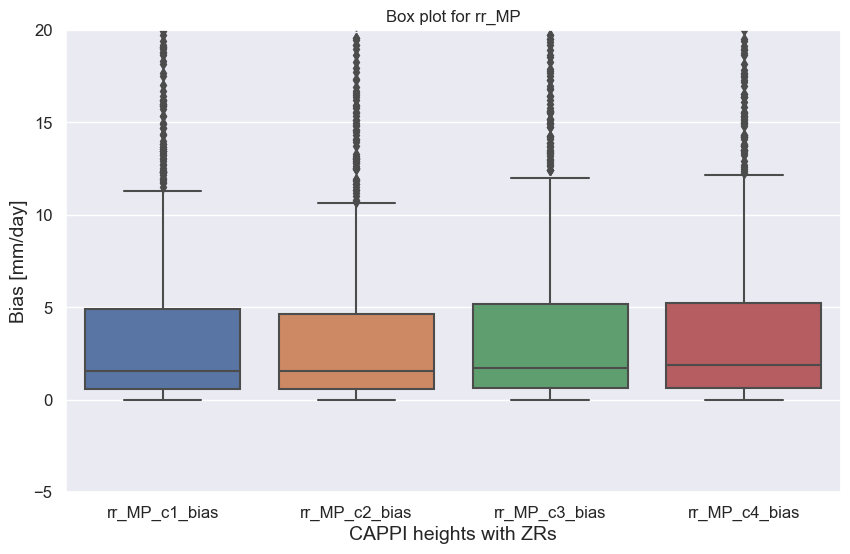

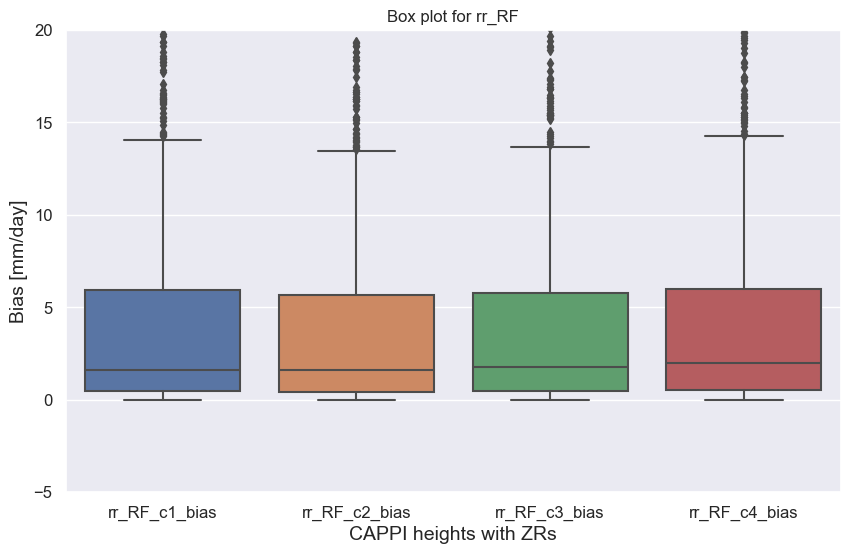

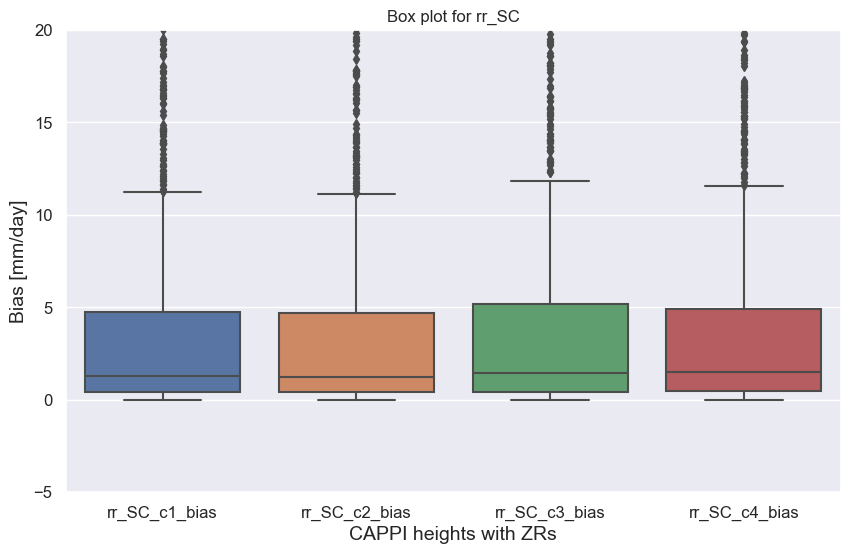

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group the columns by their prefixes
groups = {'rr_MP': ['rr_MP_c1_bias', 'rr_MP_c2_bias', 'rr_MP_c3_bias', 'rr_MP_c4_bias'],
          'rr_RF': ['rr_RF_c1_bias', 'rr_RF_c2_bias', 'rr_RF_c3_bias', 'rr_RF_c4_bias'],
          'rr_SC': ['rr_SC_c1_bias', 'rr_SC_c2_bias', 'rr_SC_c3_bias', 'rr_SC_c4_bias']}

# Plot box plots for each group
for group, columns in groups.items():
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=bias_df[columns], orient='v')
    plt.title(f'Box plot for {group}')
    plt.xlabel('CAPPI heights with ZRs')
    plt.ylabel('Bias [mm/day]')
    plt.ylim(-5, 20)  # Set y-axis limits
    plt.show()


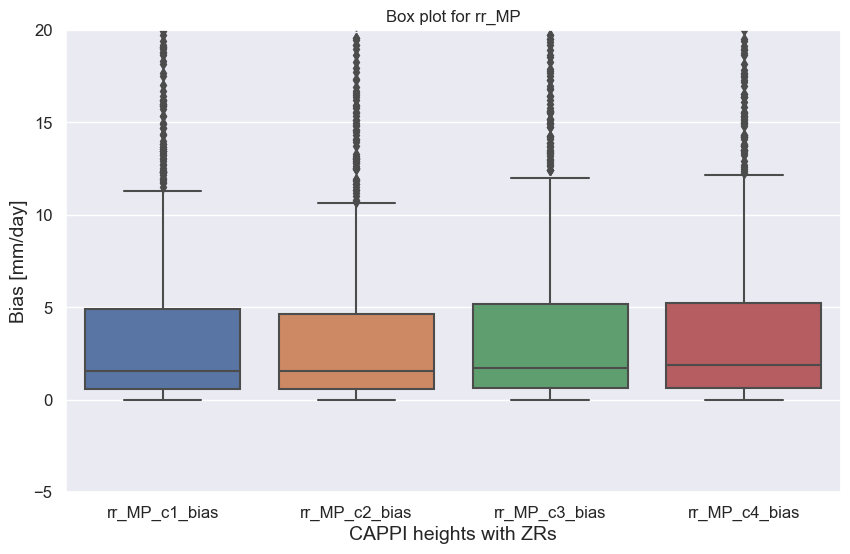

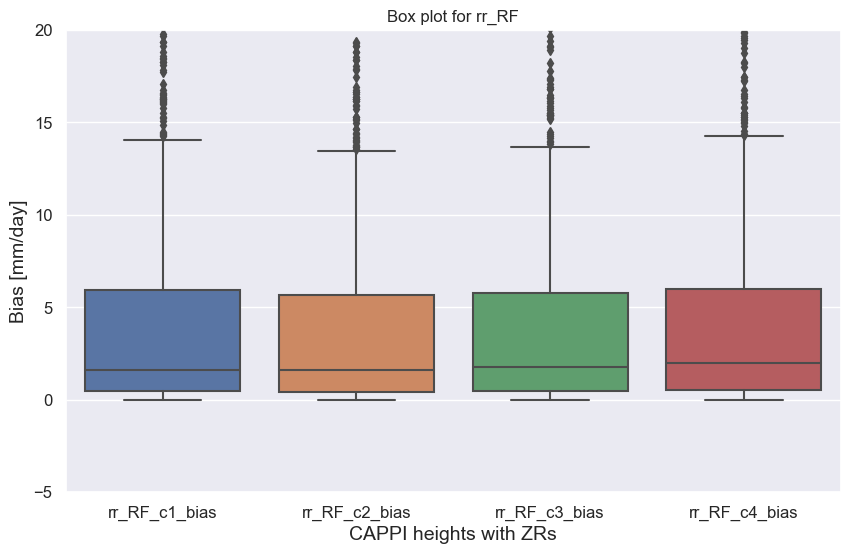

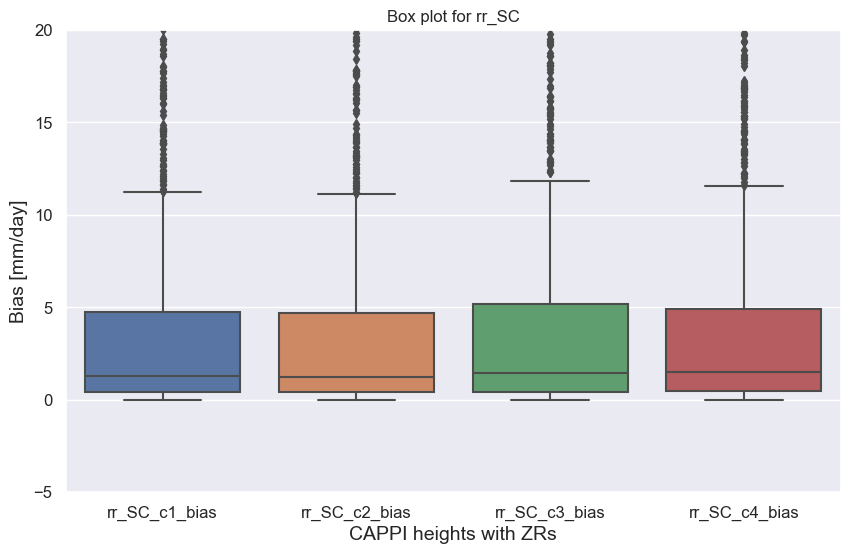

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group the columns by their prefixes
groups = {'rr_MP': ['rr_MP_c1_bias', 'rr_MP_c2_bias', 'rr_MP_c3_bias', 'rr_MP_c4_bias'],
          'rr_RF': ['rr_RF_c1_bias', 'rr_RF_c2_bias', 'rr_RF_c3_bias', 'rr_RF_c4_bias'],
          'rr_SC': ['rr_SC_c1_bias', 'rr_SC_c2_bias', 'rr_SC_c3_bias', 'rr_SC_c4_bias']}

# Plot box plots for each group
for group, columns in groups.items():
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=bias_df[columns], orient='v')
    plt.title(f'Box plot for {group}')
    plt.xlabel('CAPPI heights with ZRs')
    plt.ylabel('Bias [mm/day]')
    plt.ylim(-5, 20)  # Set y-axis limits
    plt.show()



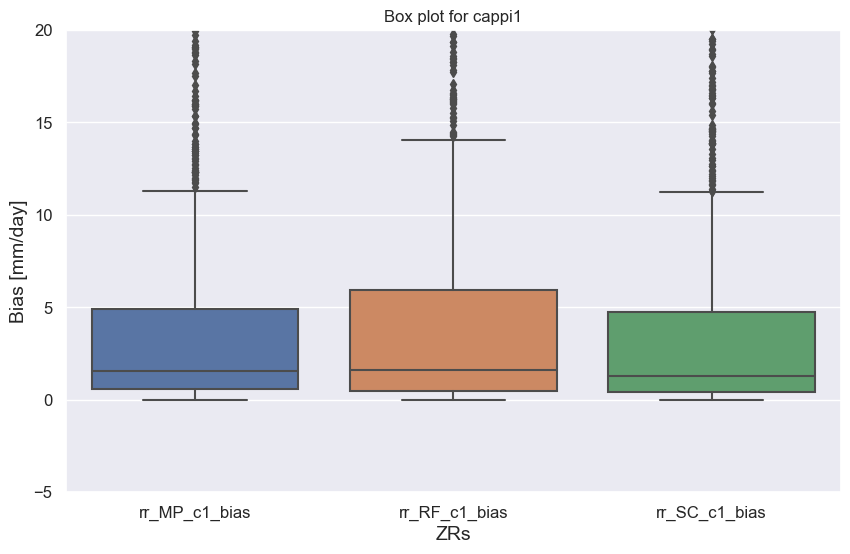

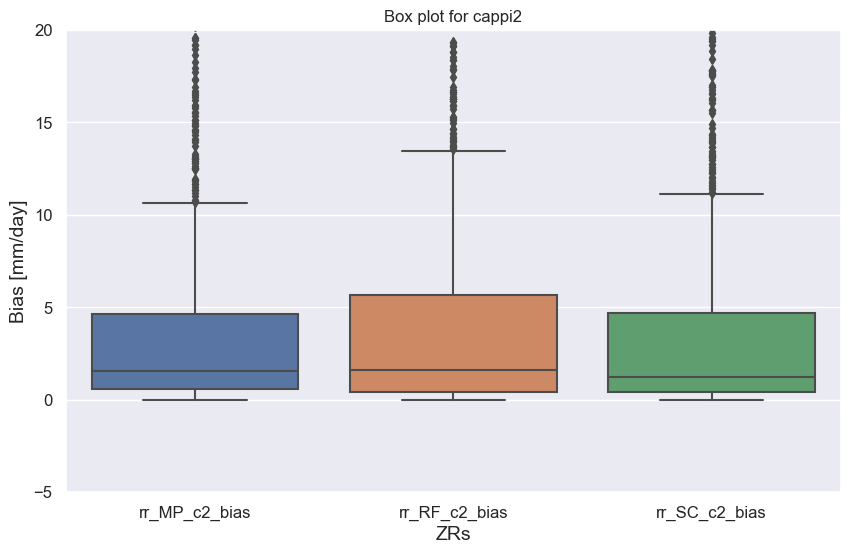

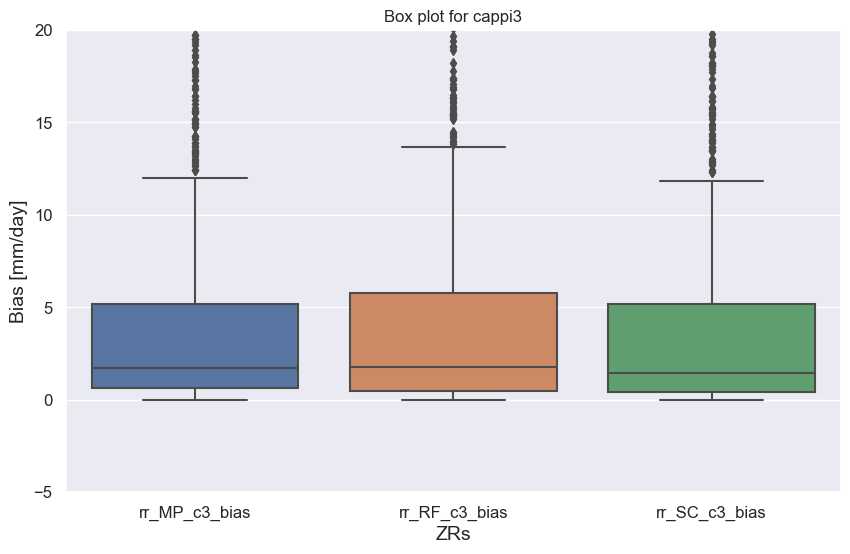

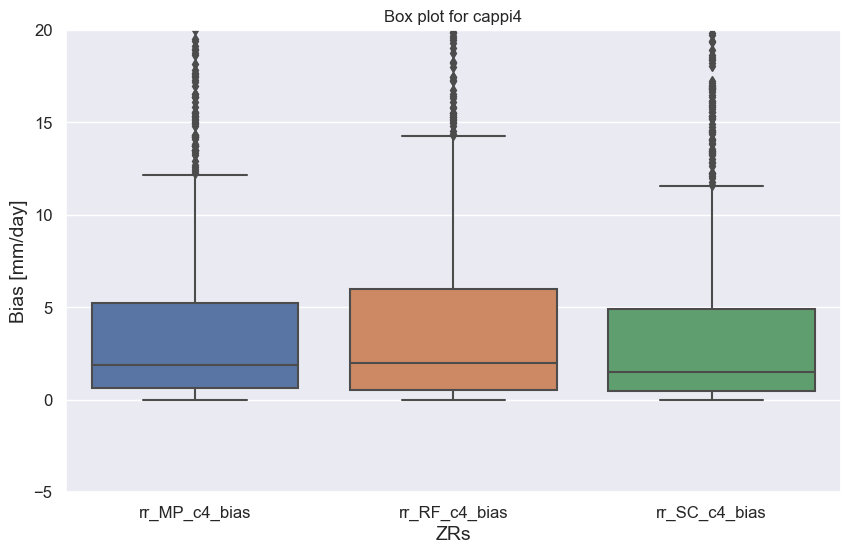

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group the columns by their prefixes
groups = {'cappi1': ['rr_MP_c1_bias', 'rr_RF_c1_bias', 'rr_SC_c1_bias'],
          'cappi2': ['rr_MP_c2_bias', 'rr_RF_c2_bias', 'rr_SC_c2_bias'],
          'cappi3': ['rr_MP_c3_bias', 'rr_RF_c3_bias', 'rr_SC_c3_bias'],
          'cappi4': ['rr_MP_c4_bias', 'rr_RF_c4_bias', 'rr_SC_c4_bias']}

# Plot box plots for each group
for group, columns in groups.items():
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=bias_df[columns], orient='v')
    plt.title(f'Box plot for {group}')
    plt.xlabel('ZRs')
    plt.ylabel('Bias [mm/day]')
    plt.ylim(-5, 20)  # Set y-axis limits
    plt.show()

### plot mean RMSE with ERROR bar with 95% CI

In [19]:
metrics_df

,RMSE,MSE,MAE,R-squared,MFB,Correlation coefficient (r),P-value
rr_MP_c1,8.025773,64.413032,4.238421,-0.206874,0.865967,0.552174,4.932250e-78
rr_MP_c2,7.548167,56.974823,4.045723,-0.232466,0.864055,0.595816,1.080381e-93
rr_MP_c3,7.789896,60.682483,4.231050,-0.187184,0.898707,0.573249,2.656772e-85
rr_MP_c4,8.022791,64.365174,4.376579,-0.303686,0.885683,0.542107,9.676419e-75
rr_RF_c1,14.072947,198.047847,5.799867,0.176757,1.222272,0.451978,1.042370e-49
rr_RF_c2,11.885513,141.265411,5.296827,0.228328,1.181694,0.512756,9.419585e-66
rr_RF_c3,14.077115,198.165154,5.522540,0.177340,1.247630,0.453930,3.559174e-50
rr_RF_c4,13.694113,187.528722,5.526864,0.135017,1.190530,0.425369,1.215028e-43
rr_SC_c1,8.642117,74.686192,4.315023,-0.170587,0.796648,0.512048,1.514116e-65
rr_SC_c2,7.957344,63.319325,4.069231,-0.214315,0.786150,0.565442,1.507053e-82


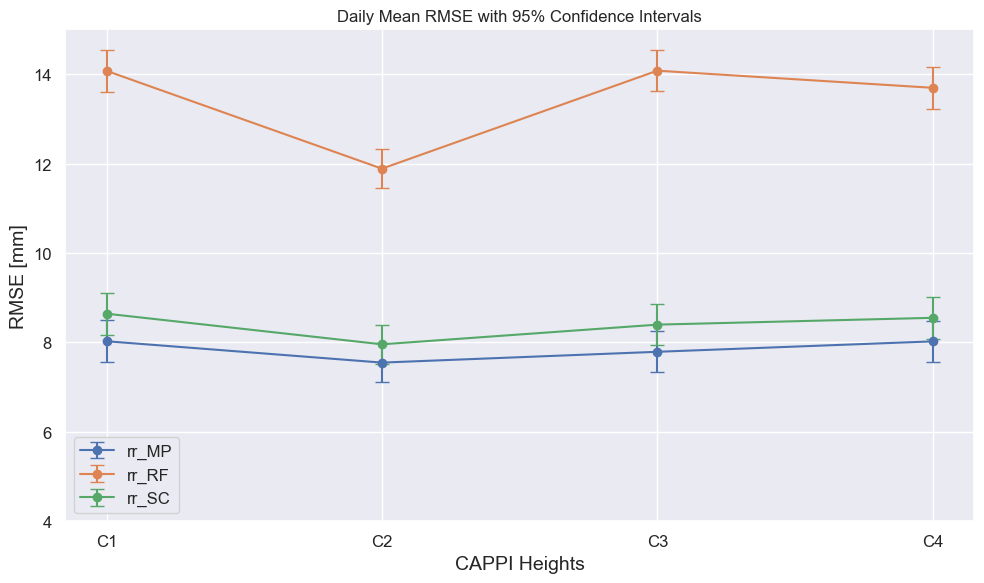

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

# Function to calculate RMSE and its confidence interval
def calculate_rmse_and_ci(data):
    rmse_values = np.sqrt((data ** 2).mean())  # Calculate RMSE
    confidence_interval = 1.96 * sem(data)  # 95% confidence interval
    return rmse_values, confidence_interval

# Group the columns by their prefixes
groups = {'rr_MP': ['rr_MP_c1_bias', 'rr_MP_c2_bias', 'rr_MP_c3_bias', 'rr_MP_c4_bias'],
          'rr_RF': ['rr_RF_c1_bias', 'rr_RF_c2_bias', 'rr_RF_c3_bias', 'rr_RF_c4_bias'],
          'rr_SC': ['rr_SC_c1_bias', 'rr_SC_c2_bias', 'rr_SC_c3_bias', 'rr_SC_c4_bias']}

# Calculate RMSE and confidence intervals for each group
mean_rmse_values = []
ci_values = []
for group, columns in groups.items():
    rmse_values = bias_df[columns]
    mean_rmse, ci = calculate_rmse_and_ci(rmse_values)
    mean_rmse_values.append(mean_rmse)
    ci_values.append(ci)

    
mean_rmse_values_float = np.array(mean_rmse_values)    
column_names = [
    ['rr_MP_c1_bias', 'rr_MP_c2_bias', 'rr_MP_c3_bias', 'rr_MP_c4_bias'],
    ['rr_RF_c1_bias', 'rr_RF_c2_bias', 'rr_RF_c3_bias', 'rr_RF_c4_bias'],
    ['rr_SC_c1_bias', 'rr_SC_c2_bias', 'rr_SC_c3_bias', 'rr_SC_c4_bias']
]

# Transform the data into the desired format
mean_rmse_values = []
for i in range(len(mean_rmse_values_float)):
    group_dict = {}
    for j, column_name in enumerate(column_names[i]):
        group_dict[column_name] = mean_rmse_values_float[i][j]
    mean_rmse_values.append(group_dict)


ci_values = np.array(ci_values)


# Group names
groups = ['rr_MP', 'rr_RF', 'rr_SC']

# Plot line graph with error bars
plt.figure(figsize=(10, 6))

# Plot lines for mean RMSE values
for i, group in enumerate(groups):
    mean_values = list(mean_rmse_values[i].values())
    plt.errorbar(range(1, 5), mean_values, yerr=ci, label=group, marker='o', capsize=5)
    #plt.errorbar(range(1, 5), mean_values, yerr=ci_values[i], label=group)

plt.xlabel('CAPPI Heights')
plt.ylabel('RMSE [mm]')
plt.title('Daily Mean RMSE with 95% Confidence Intervals')
plt.ylim(4,15)
plt.xticks(range(1, 5), ['C1', 'C2', 'C3', 'C4'])  # Assuming x-axis labels are column numbers
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


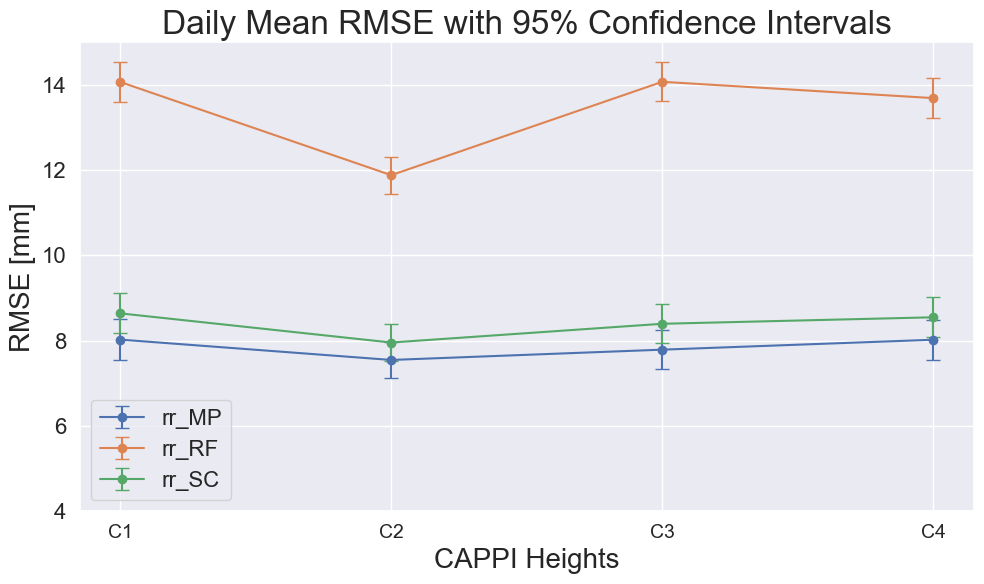

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

# Function to calculate RMSE and its confidence interval
def calculate_rmse_and_ci(data):
    rmse_values = np.sqrt((data ** 2).mean())  # Calculate RMSE
    confidence_interval = 1.96 * sem(data)  # 95% confidence interval
    return rmse_values, confidence_interval

# Group the columns by their prefixes
groups = {'rr_MP': ['rr_MP_c1_bias', 'rr_MP_c2_bias', 'rr_MP_c3_bias', 'rr_MP_c4_bias'],
          'rr_RF': ['rr_RF_c1_bias', 'rr_RF_c2_bias', 'rr_RF_c3_bias', 'rr_RF_c4_bias'],
          'rr_SC': ['rr_SC_c1_bias', 'rr_SC_c2_bias', 'rr_SC_c3_bias', 'rr_SC_c4_bias']}

# Calculate RMSE and confidence intervals for each group
mean_rmse_values = []
ci_values = []
for group, columns in groups.items():
    rmse_values = bias_df[columns]
    mean_rmse, ci = calculate_rmse_and_ci(rmse_values)
    mean_rmse_values.append(mean_rmse)
    ci_values.append(ci)

    
mean_rmse_values_float = np.array(mean_rmse_values)    
column_names = [
    ['rr_MP_c1_bias', 'rr_MP_c2_bias', 'rr_MP_c3_bias', 'rr_MP_c4_bias'],
    ['rr_RF_c1_bias', 'rr_RF_c2_bias', 'rr_RF_c3_bias', 'rr_RF_c4_bias'],
    ['rr_SC_c1_bias', 'rr_SC_c2_bias', 'rr_SC_c3_bias', 'rr_SC_c4_bias']
]

# Transform the data into the desired format
mean_rmse_values = []
for i in range(len(mean_rmse_values_float)):
    group_dict = {}
    for j, column_name in enumerate(column_names[i]):
        group_dict[column_name] = mean_rmse_values_float[i][j]
    mean_rmse_values.append(group_dict)


ci_values = np.array(ci_values)


# Group names
groups = ['rr_MP', 'rr_RF', 'rr_SC']

# Plot line graph with error bars
plt.figure(figsize=(10, 6))

# Plot lines for mean RMSE values
for i, group in enumerate(groups):
    mean_values = list(mean_rmse_values[i].values())
    plt.errorbar(range(1, 5), mean_values, yerr=ci, label=group, marker='o', capsize=5)
    #plt.errorbar(range(1, 5), mean_values, yerr=ci_values[i], label=group)

plt.xlabel('CAPPI Heights', fontsize=20)
plt.ylabel('RMSE [mm]', fontsize=20)
plt.title('Daily Mean RMSE with 95% Confidence Intervals', fontsize=24)
plt.ylim(4,15)
plt.xticks(range(1, 5), ['C1', 'C2', 'C3', 'C4'], fontsize=14)  # Assuming x-axis labels are column numbers
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()
